# Stock Prediction

This project introduces common techniques to manipulate time series and make predictions.

The data is sample from the historical US stock prices in the last 
5 years.
Only the New German Fund (GF) will be considered for analysis.

There roughly 1000 days of recorded trading for GF

# Clean Data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook
from itertools import product

def mean_absolute_percentage_error(y_true,y_pred):
    return np.mean(np.abs((y_true-y_pred) / y_pred)) *100

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [23]:
# loading the data
data = pd.read_csv("stock_price_sample.csv", index_col=["DATE"], parse_dates=["DATE"])
data.head(10)

,TICKER,FIGI,TYPE,FREQUENCY,OPEN,HIGH,LOW,CLOSE,VOLUME,ADJ_OPEN,ADJ_HIGH,ADJ_LOW,ADJ_CLOSE,ADJ_VOLUME,ADJ_FACTOR,EX_DIVIDEND,SPLIT_RATIO
DATE,,,,,,,,,,,,,,,,,
2013-01-04,GEF,BBG000BLFQH8,EOD,daily,46.31,47.6198,46.2300,47.3700,248000,38.517220,39.606614,38.450681,39.398849,248000,NaN,0.0,1
2013-01-03,GEF,BBG000BLFQH8,EOD,daily,46.43,46.5200,46.1400,46.4800,131300,38.617027,38.691882,38.375826,38.658613,131300,NaN,0.0,1
2013-01-02,GEF,BBG000BLFQH8,EOD,daily,45.38,46.5400,45.1600,46.4100,184900,37.743715,38.708516,37.560735,38.600392,184900,NaN,0.0,1
2018-06-05,GF,BBG000C3C6S2,Intraday,daily,18.86,18.9100,18.8700,18.8700,10000,18.860000,18.910000,18.870000,18.870000,10000,NaN,0.0,1
2018-06-04,GF,BBG000C3C6S2,EOD,daily,18.86,18.8900,18.7900,18.8100,39095,18.860000,18.890000,18.790000,18.810000,39095,NaN,0.0,1
2018-06-01,GF,BBG000C3C6S2,EOD,daily,18.58,18.7600,18.5800,18.7400,17468,18.580000,18.760000,18.580000,18.740000,17468,NaN,0.0,1
2018-05-31,GF,BBG000C3C6S2,EOD,daily,18.52,18.5200,18.3012,18.4900,22384,18.520000,18.520000,18.301200,18.490000,22384,NaN,0.0,1
2018-05-30,GF,BBG000C3C6S2,EOD,daily,18.47,18.6780,18.4700,18.6500,22633,18.470000,18.678000,18.470000,18.650000,22633,NaN,0.0,1
2018-05-29,GF,BBG000C3C6S2,EOD,daily,18.51,18.5100,18.1500,18.2562,67412,18.510000,18.510000,18.150000,18.256200,67412,NaN,0.0,1


In [24]:
data.shape


(999, 17)

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 999 entries, 2013-01-04 to 2014-06-23
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   TICKER       999 non-null    object 
 1   FIGI         999 non-null    object 
 2   TYPE         999 non-null    object 
 3   FREQUENCY    999 non-null    object 
 4   OPEN         999 non-null    float64
 5   HIGH         999 non-null    float64
 6   LOW          999 non-null    float64
 7   CLOSE        999 non-null    float64
 8   VOLUME       999 non-null    int64  
 9   ADJ_OPEN     999 non-null    float64
 10  ADJ_HIGH     999 non-null    float64
 11  ADJ_LOW      999 non-null    float64
 12  ADJ_CLOSE    999 non-null    float64
 13  ADJ_VOLUME   999 non-null    int64  
 14  ADJ_FACTOR   7 non-null      float64
 15  EX_DIVIDEND  999 non-null    float64
 16  SPLIT_RATIO  999 non-null    int64  
dtypes: float64(10), int64(3), object(4)
memory usage: 140.5+ KB


In [26]:
data.dtypes

TICKER          object
FIGI            object
TYPE            object
FREQUENCY       object
OPEN           float64
HIGH           float64
LOW            float64
CLOSE          float64
VOLUME           int64
ADJ_OPEN       float64
ADJ_HIGH       float64
ADJ_LOW        float64
ADJ_CLOSE      float64
ADJ_VOLUME       int64
ADJ_FACTOR     float64
EX_DIVIDEND    float64
SPLIT_RATIO      int64
dtype: object

In [27]:
data = data[data.TICKER != "GEF"]
data = data[data.TYPE != "Intraday"]

In [28]:
data.shape

(995, 17)

In [29]:
data.TYPE.unique()


array(['EOD'], dtype=object)

In [30]:
data.TICKER.unique()

array(['GF'], dtype=object)

In [31]:
data.head()

,TICKER,FIGI,TYPE,FREQUENCY,OPEN,HIGH,LOW,CLOSE,VOLUME,ADJ_OPEN,ADJ_HIGH,ADJ_LOW,ADJ_CLOSE,ADJ_VOLUME,ADJ_FACTOR,EX_DIVIDEND,SPLIT_RATIO
DATE,,,,,,,,,,,,,,,,,
2018-06-04,GF,BBG000C3C6S2,EOD,daily,18.86,18.890,18.7900,18.8100,39095,18.86,18.890,18.7900,18.8100,39095,NaN,0.0,1
2018-06-01,GF,BBG000C3C6S2,EOD,daily,18.58,18.760,18.5800,18.7400,17468,18.58,18.760,18.5800,18.7400,17468,NaN,0.0,1
2018-05-31,GF,BBG000C3C6S2,EOD,daily,18.52,18.520,18.3012,18.4900,22384,18.52,18.520,18.3012,18.4900,22384,NaN,0.0,1
2018-05-30,GF,BBG000C3C6S2,EOD,daily,18.47,18.678,18.4700,18.6500,22633,18.47,18.678,18.4700,18.6500,22633,NaN,0.0,1
2018-05-29,GF,BBG000C3C6S2,EOD,daily,18.51,18.510,18.1500,18.2562,67412,18.51,18.510,18.1500,18.2562,67412,NaN,0.0,1


In [32]:
# we remove the unwanted columns, as we solely want to focus on
# the stock closing price

drop_cols = ["SPLIT_RATIO","EX_DIVIDEND","ADJ_FACTOR","ADJ_VOLUME",
             "ADJ_CLOSE","ADJ_LOW","ADJ_HIGH","ADJ_OPEN","VOLUME",
             "FREQUENCY","TYPE","FIGI"]
data.drop(drop_cols,axis=1,inplace=True)
data.head()

,TICKER,OPEN,HIGH,LOW,CLOSE
DATE,,,,,
2018-06-04,GF,18.86,18.890,18.7900,18.8100
2018-06-01,GF,18.58,18.760,18.5800,18.7400
2018-05-31,GF,18.52,18.520,18.3012,18.4900
2018-05-30,GF,18.47,18.678,18.4700,18.6500
2018-05-29,GF,18.51,18.510,18.1500,18.2562


# Exploratory data analysis(EDA)

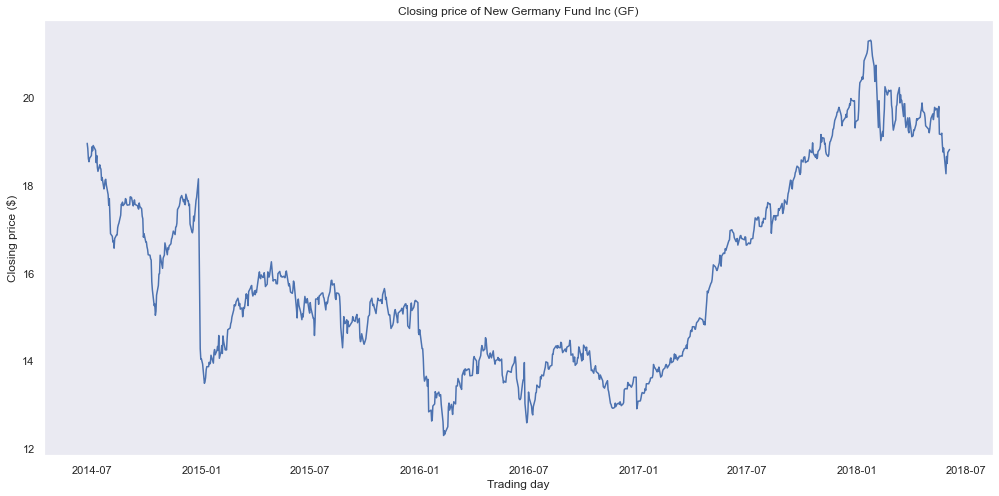

In [35]:
# plot the closing price over the entire time period of our
# dataset

plt.figure(figsize=(17,8))
plt.plot(data.CLOSE)
plt.title("Closing price of New Germany Fund Inc (GF)")
plt.ylabel("Closing price ($)")
plt.xlabel("Trading day")
plt.grid(False)
plt.show()

clearly, this is not a stationay process, and it is hard to tell if there is some kind of seasonality.

# Moving average

let's use the moving average model to smooth our time series. For that, we will use a helper fuction that will run the moving average model on a specified time window and it will plot the result smoothed curve:

In [53]:
def plot_moving_average(series, window, plot_intervals=False, scale= 1.96):
    
    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")
    
    # plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:],rolling_mean[window:])
        deviation = np.std(series[window:]-rolling_mean[window:])
        lower_bound = rolling_mean - (mae+scale *deviation)
        upper_bound = rolling_mean + (mae+scale *deviation)
        plt.plot(upper_bound, 'r--', label = "Upper bound/Lower bound")
        plt.plot(lower_bound, 'r--')
        
    plt.plot(series[window:],label="Actual values")
    plt.legend(loc="best")
    plt.grid(True)
    


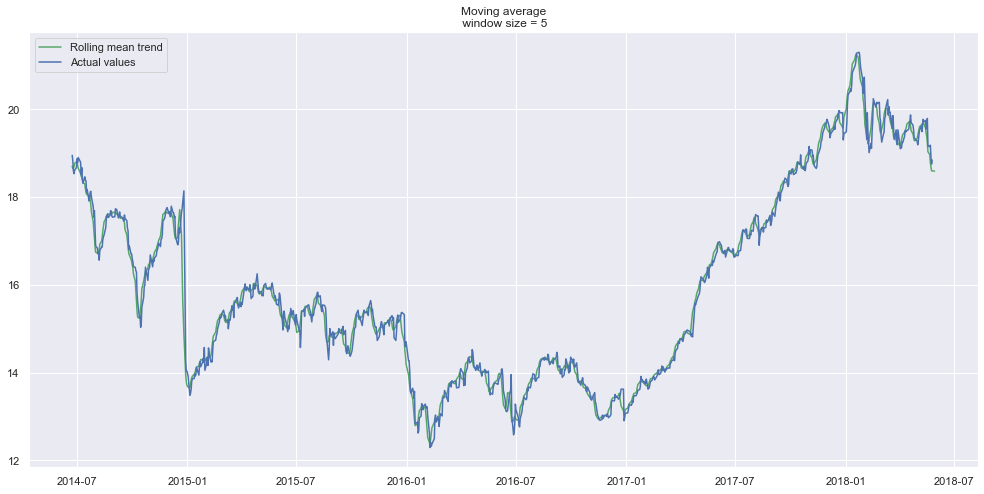

In [54]:
# smooth by the previous month (30days)
plot_moving_average(data.CLOSE, 5)

we can hardly see a trend, because it is too close to actual curve. Let's see the result of smoothing by the previous month,
and previous quater.

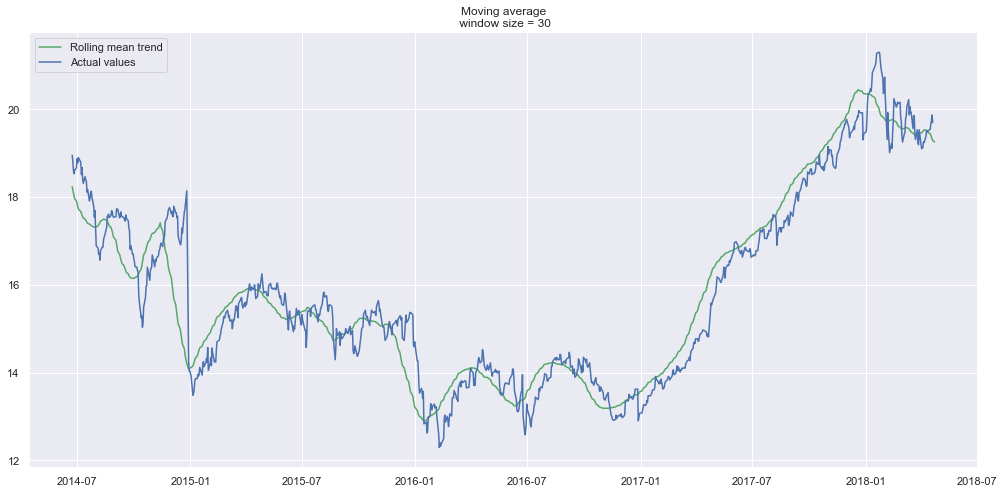

In [55]:
# smooth by the previous month(30 days)
plot_moving_average(data.CLOSE,30)

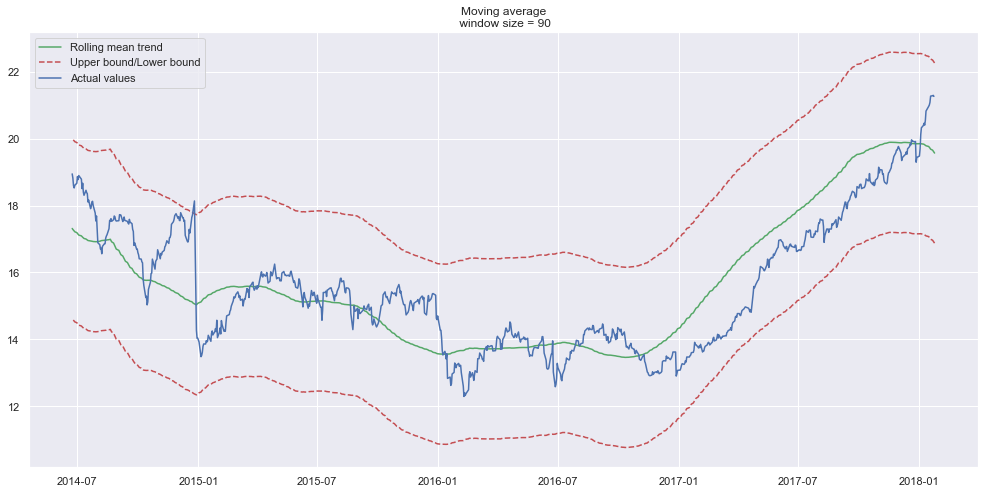

In [57]:
# Smooth by the previous quater(90 days)
plot_moving_average(data.CLOSE, 90, plot_intervals=True)

Trends are easier to spot now. Notice how the 30 day an 90-day trend show a downward curve at the end. This might mean that the stock is likely to go down in the the following days.

# Exponential smoothing
Now, let's use exponential smoothing to see if it can pick up a better trend

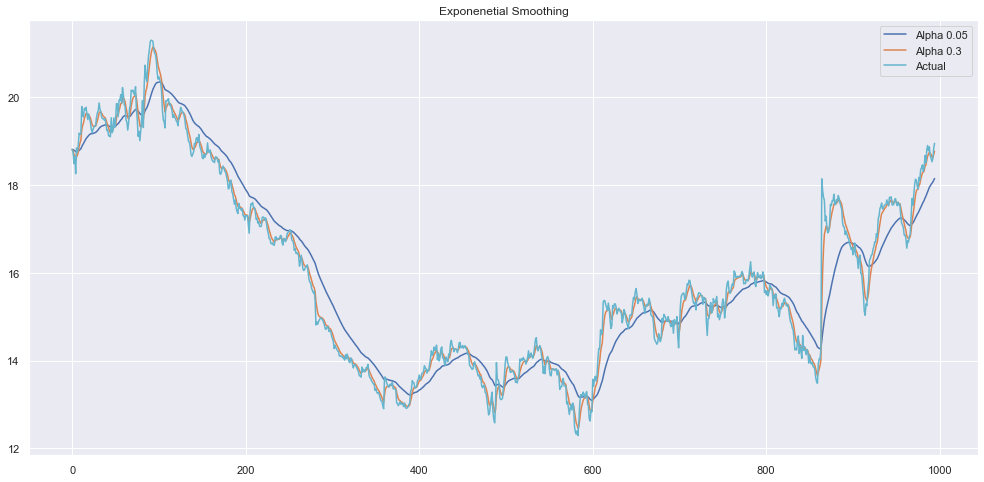

In [60]:
def exponential_smoothing(series,alpha):
    
    result = [series[0]] # first value is same as series
    for n in range(1,len(series)):
        result.append(alpha * series[n] + (1-alpha) *result[n-1])
    return result

def plot_exponential_smoothing(series,alphas):
    
    plt.figure(figsize=(17,8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series,alpha),label="Alpha {}".format(alpha))
    plt.plot(series.values, "c",label="Actual")
    plt.legend(loc='best')
    plt.axis('tight')
    plt.title("Exponenetial Smoothing")
    plt.grid(True)
        
plot_exponential_smoothing(data.CLOSE, [0.05,0.3])

here, we use 0.05 and 0.3 as values for the smoothing factor.

an alpha value of 0.05 smoothed the curve while picking up most of the upward and downward trends.

# Double exponential smoothing

In [71]:
def double_exponential_smoothing(series, alpha,beta):
    
    result = [series[0]]
    for n in range(1,len(series)+1):
        if n ==1:
            level , trend = series[0], series[1]-series[0]
        if n>= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level , level = level, alpha *value + (1-alpha) *(level +trend)
        trend = beta * (level - last_level) + (1-beta) *trend
        result.append(level+trend)
        
    return result

def plot_double_exponential_smoothing(series, alphas, betas):
    
    plt.figure(figsize = (17,8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series,alpha,beta),label="Alpha {}, beta {}".format(alpha,beta))
    plt.plot(series.values, label= "Actual")
    plt.legend(loc='best')
    plt.axis("tight")
    plt.title("Double Exponential Smoothing")
    plt.grid(True)
        

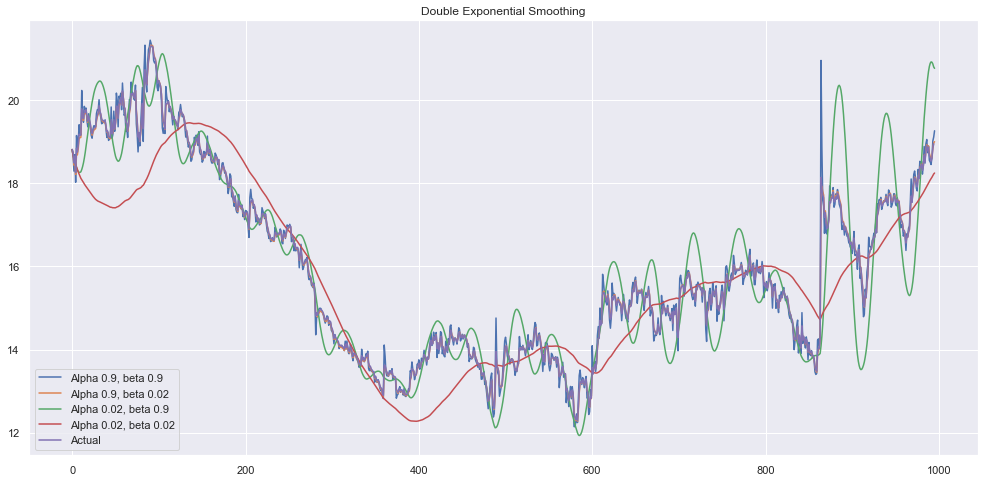

In [72]:
plot_double_exponential_smoothing(data.CLOSE,alphas=[0.9,0.02],betas=[0.9,0.02])

Again, experiment with different alpha and beta combinations to get better looking curves.

# Modelling

As outlined previously, we must turn our series into stationary process in order to model it. Therefore, let's apply teh Dickey-Fuller test to see if it is a stationary process:

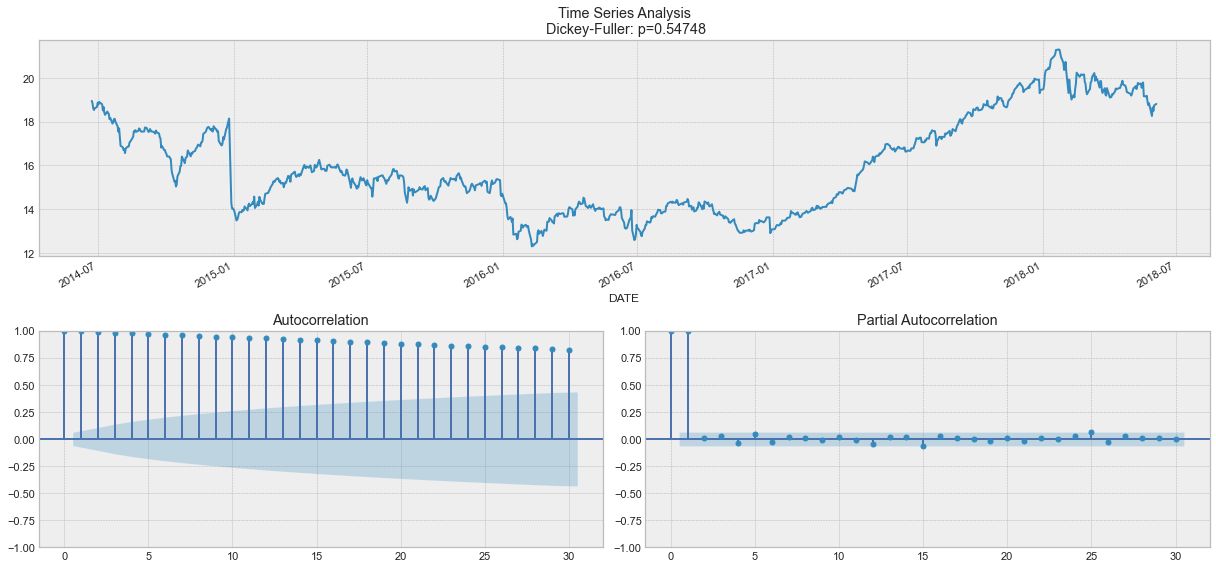

In [77]:
def tsplot(y, lags = None, figsize=(17,8), sytle = 'bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    
    with plt.style.context(style = 'bmh'):
        fig = plt.figure(figsize = figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax = ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title("Time Series Analysis\n Dickey-Fuller: p={0:.5f}".format(p_value))
        smt.graphics.plot_acf(y,lags = lags , ax = acf_ax)
        smt.graphics.plot_pacf(y, lags= lags, ax = pacf_ax)
        plt.tight_layout()
        
tsplot(data.CLOSE, lags = 30)

By the Dickey_Fuller test, the time series is unsurprisingly non-stationary. Also, looking at the autocorrelation plot, we see that it is very high, and it seems that there is no clear seasonality.

Therefore, to get rid of the high autocorrelation and to make the process stationary, let's take the first difference . we simply subtract the time series from itself with a lag of one day, and we get:

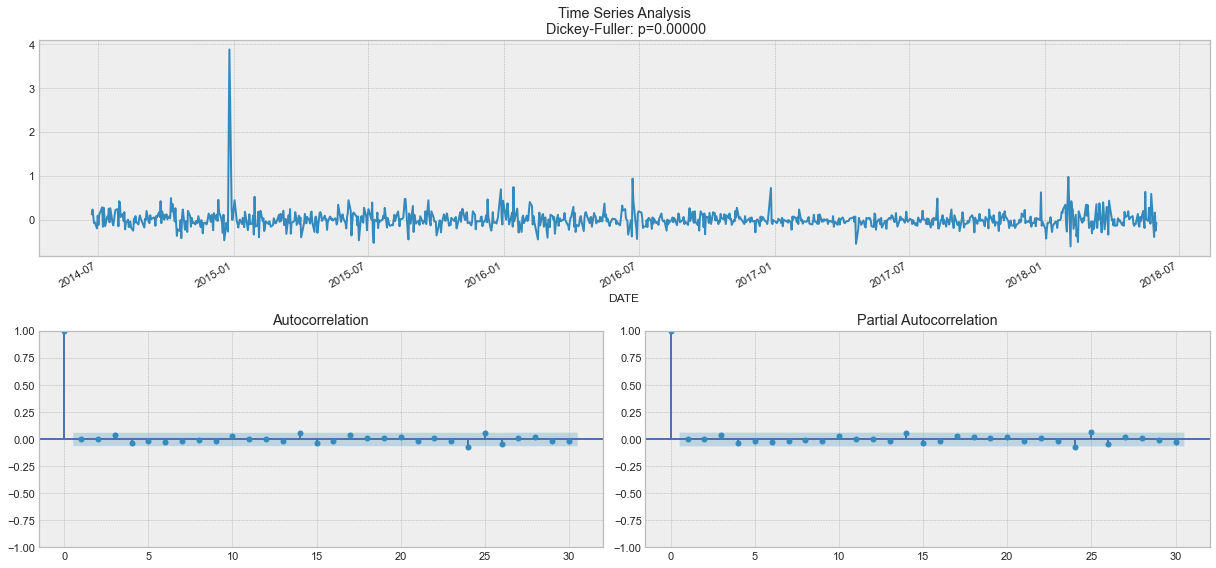

In [78]:
# Take the first difference to remove make the process stationary

data_diff = data.CLOSE - data.CLOSE.shift(1)

tsplot(data_diff[1:], lags = 30)

Awesome! Our series in now stationary and we can start modelling!

# SARIMA

Now, for SARIMA, we first define a few parameters and a range of values for other parameters to generate a list of all possible combinations of p, q, d, P, Q, D, s.

Now, in the code cell above, we have 625 different combinations! We will try each combination and train SARIMA with each so to find the best performing model.

In [82]:
# set initial values and some bounds
ps = range(0,5)
d = 1
qs = range(0,5)
Ps = range(0,5)
D = 1
Qs = range(0,5)
s = 5

# Create a list with all possible combinations of parameters
parameters = product(ps,qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

625

In [91]:
def optimize_SARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
    """
    
    results = []
    best_aic = float('inf')
    
    for param in tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(data.CLOSE, order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        
        #Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    return result_table

result_table = optimize_SARIMA(parameters_list, d, D, s)

  0%|          | 0/625 [00:00<?, ?it/s]

In [92]:
result_table

,parameters,aic
0,"(0, 0, 2, 4)",-283.748034
1,"(0, 0, 3, 3)",-283.748030
2,"(0, 0, 2, 3)",-283.496284
3,"(0, 0, 0, 1)",-282.957737
4,"(0, 0, 3, 4)",-282.534600
...,...,...
620,"(4, 0, 0, 0)",389.879202
621,"(2, 1, 0, 0)",390.973501
622,"(1, 2, 0, 0)",390.995839
623,"(3, 1, 0, 0)",391.356516


In [95]:
# set parameter that give the lowest AIC

p,q,P,Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(data.CLOSE, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                          SARIMAX Results                                           
Dep. Variable:                                        CLOSE   No. Observations:                  995
Model:             SARIMAX(0, 1, 0)x(2, 1, [1, 2, 3, 4], 5)   Log Likelihood                 148.874
Date:                                      Thu, 13 Oct 2022   AIC                           -283.748
Time:                                              23:58:21   BIC                           -249.471
Sample:                                                   0   HQIC                          -270.713
                                                      - 995                                         
Covariance Type:                                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L5       -0.5012      0.162  

In [97]:
def plot_SARIMA(series, model, n_steps):
    """
        Plot model vs predicted values
        
        series - dataset with time series
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
    """
    
    data = series.copy().rename(columns = {'CLOSE': 'actual'})
    data['arima_model'] = model.fittedvalues
    #Make a shift on s+d steps, because these values were unobserved by the model due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    #Forecast on n_steps forward
    forecast = model.predict(start=data.shape[0], end=data.shape[0] + n_steps)
    forecast = data.arima_model.append(forecast)
    #Calculate error
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])
    
    plt.figure(figsize=(17, 8))
    plt.title('Mean Absolute Percentage Error: {0:.2f}%'.format(error))
    plt.plot(forecast, color='r', label='model')
    plt.axvspan(data.index[-1], forecast.index[-1],alpha=0.5, color='lightgrey')
    plt.plot(data, label='actual')
    plt.legend()
    plt.grid(True);
    
#plot_SARIMA(data, best_model, 5)
print(best_model.predict(start=data.CLOSE.shape[0], end=data.CLOSE.shape[0] + 5))
print(mean_absolute_percentage_error(data.CLOSE[s+d:], best_model.fittedvalues[s+d:]))

995     18.959083
996     18.965938
997     18.960926
998     18.923374
999     18.945276
1000    18.923411
Name: predicted_mean, dtype: float64
0.792741253635935


Awesome! We finally predict the closing price of the next five trading days and evaluate the MAPE of the model.

In this case, we have a MAPE of 0.79%, which is very good!

Now, to compare our prediction with actual data, we take financial data from Yahoo Finance and create a dataframe.

Then, we make a plot to see how far we were from the actual closing prices:

In [98]:
comparison = pd.DataFrame({'actual': [18.93, 19.23, 19.08, 19.17, 19.11, 19.12],
                          'predicted': [18.96, 18.97, 18.96, 18.92, 18.94, 18.92]}, 
                          index = pd.date_range(start='2018-06-05', periods=6,))

In [100]:
comparison.head()

,actual,predicted
2018-06-05,18.93,18.96
2018-06-06,19.23,18.97
2018-06-07,19.08,18.96
2018-06-08,19.17,18.92
2018-06-09,19.11,18.94


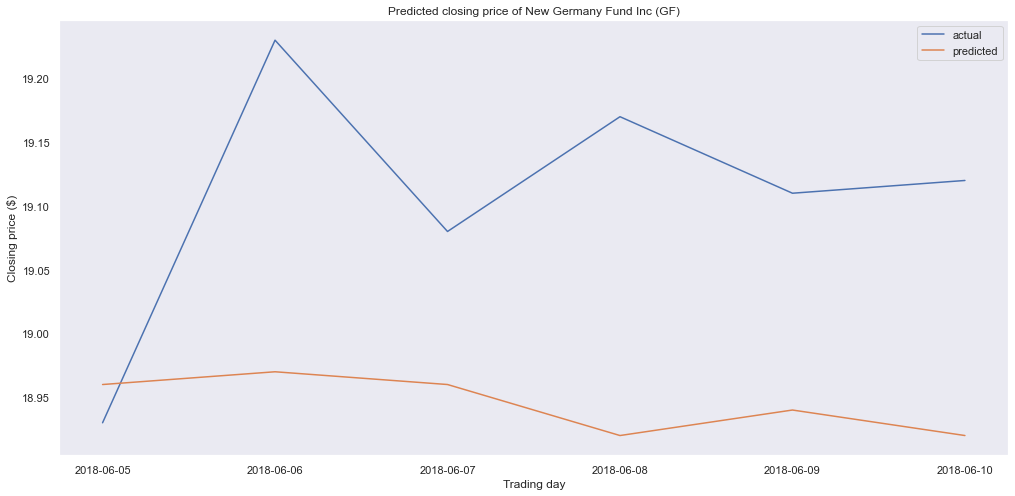

In [102]:
plt.figure(figsize=(17, 8))
plt.plot(comparison.actual,label = "actual")
plt.plot(comparison.predicted,label="predicted")
plt.title('Predicted closing price of New Germany Fund Inc (GF)')
plt.ylabel('Closing price ($)')
plt.xlabel('Trading day')
plt.legend(loc='best')
plt.grid(False)
plt.show()

It seems that we are a bit off in our predictions. In fact, the predicted price is essentially flat, meaning that our model is probably not performing well.

Again, this is not due to our procedure, but to the fact that predicting stock prices is essentially impossible.

In [106]:
# we learned the entire procedure of making a time series stationary before using SARIMA to model. It is a long and tedious process, with a lot of manual tweaking.